## TODO
1. Plot net load curve
1. Source for emissions
1. Add generation mix for CO2 cap
1. Plot opt capacity for weather years (change Co2 cap?)
1. Fix hydro CF

## Task A: optimize a region

In [99]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import pypsa 
import warnings
import os
import sys
import contextlib
warnings.filterwarnings("ignore")

# Function to reduce console print of optimizer
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Import datasets for region and year of interest
country = "FIN"
year = 2015

demand_all = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True )
demand_all.index = demand_all.index.tz_localize(None)
demand = demand_all[country].loc[demand_all.index.year == year]

onshore_all = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore_all.index = onshore_all.index.tz_localize(None)
onshore_2015 = onshore_all[country].loc[onshore_all.index.year == year]

solar_all = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar_all.index = solar_all.index.tz_localize(None)
solar_2015 = solar_all[country].loc[solar_all.index.year == year]

heat_all = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat_all.index = heat_all.index.tz_localize(None)
heat = heat_all[country].loc[solar_2015.index.year == year]

# Import hydro data
hydro_all = pd.read_csv("hydro.csv", sep=";", index_col=0, parse_dates=True)
hydro_all = hydro_all["Hydro power production - real time data"]
hydro_all.index = hydro_all.index.tz_localize(None)
hydro_all = hydro_all.resample("H").mean()/3100 # Estimate capacity factor based on current installed capacity of 3.1 GW
hydro_all = hydro_all.fillna(method="ffill") # Fill NaN with previous value
hydro_2015 = hydro_all.loc[hydro_all.index.year == year]

# Get snapshots for the year of interest
snapshots = demand.index


In [100]:
# Annuity function for converging capital costs to annualized costs
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

# Import costs from PyPSA technology data
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert cost units to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

# Set OCGT cost and emissions to gas values
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Set OCGT cost and emissions to gas values
costs.at["biomass CHP", "CO2 intensity"] = costs.at["solid biomass", "CO2 intensity"]
costs.at["biomass CHP", "fuel"] = costs.at["solid biomass", "fuel"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [101]:
# Define the original range
original_start = hydro_all.index.min()
original_end = hydro_all.index.max()

# Target range
start_target = pd.Timestamp('1979-01-01 00:00')
end_target = pd.Timestamp('2017-12-31 23:00')

# Duration of the original data
original_duration = original_end - original_start + pd.Timedelta(hours=1)  # inclusive last hour

# Create empty list
extended_data = []

# Start copying
current_start = start_target

while current_start <= end_target:
    temp_df = hydro_all.copy()
    shift = current_start - original_start
    temp_df.index = temp_df.index + shift
    
    # Keep only data within the target range
    temp_df = temp_df[(temp_df.index >= start_target) & (temp_df.index <= end_target)]
    
    extended_data.append(temp_df)
    
    # Update current_start
    current_start += original_duration

# Combine all copies
hydro_extended = pd.concat(extended_data)



In [102]:
# Create a PyPSA network
network = pypsa.Network()
network.set_snapshots(snapshots.values)

# Add electricity bus
network.add("Bus", "FIN_el")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    "biomass CHP",
    "coal",
    "hydro",
]

colors = ["dodgerblue", "gold", "brown", "blue", "green", "orange", "red", "purple"]

# Add carriers to the network with CO2 emissions and colors
for i, carrier in enumerate(carriers):
    network.add("Carrier", carrier, co2_emissions=costs.at[carrier, "CO2 intensity"], color=colors[i])

# Define capacity factors for each carrier
CF = pd.DataFrame(1, index=snapshots, columns=carriers)
CF = CF.assign(onwind=onshore_2015.values, solar=solar_2015.values, hydro=hydro_2015.values )

# Add electricity load
network.add("Load", "el_load", bus="FIN_el", p_set=demand.values)

# Add generators
for carrier in carriers:
        network.add("Generator", carrier, bus="FIN_el", p_nom_extendable=True, 
                    p_max_pu      = CF[carrier].values,
                    marginal_cost = costs.at[carrier, "marginal_cost"], 
                    efficiency    = costs.at[carrier, "efficiency"], 
                    capital_cost  = costs.at[carrier, "capital_cost"], 
                    carrier       = carrier
        )

# Limit the capacity of hydro
network.generators.loc["hydro", "p_nom_max"] = 3100 # MW


# Optimize with reduced output
# Suppress the solver output by using the context manager
with suppress_stdout():
    network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s]
INFO:linopy.io: Writing time: 0.93s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-j8kjp6w0.lp
INFO:gurobipy:Reading time = 0.26 seconds
INFO:gurobipy:obj: 131408 rows, 61327 columns, 241259 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131408 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


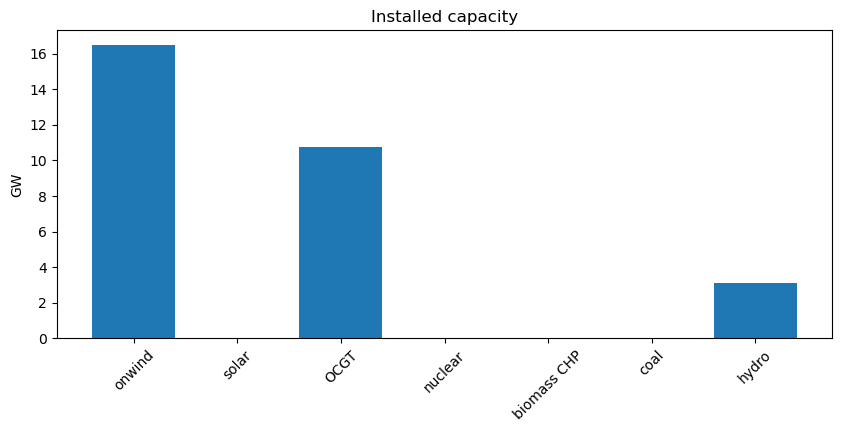

In [103]:
# Extract results
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

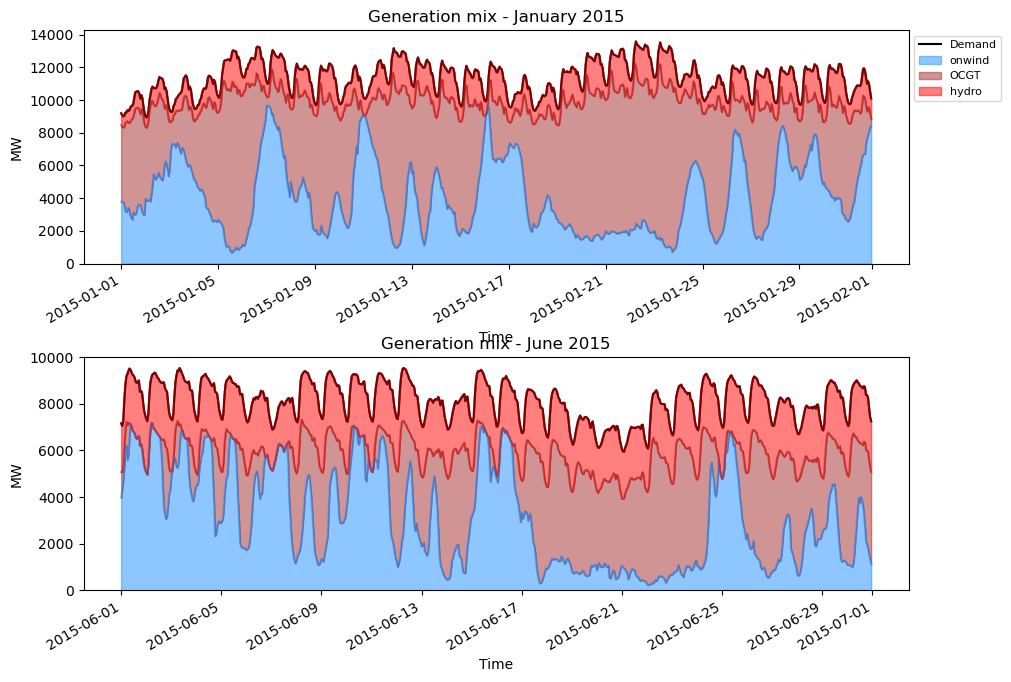

In [104]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-31"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-30"

demand_jan = demand.loc[start_date_jan:end_date_jan]
generator_jan = gen_prod.loc[start_date_jan:end_date_jan,  (gen_prod != 0).any(axis=0)]

demand_jun = demand.loc[start_date_jun:end_date_jun, ]
generator_jun = gen_prod.loc[start_date_jun:end_date_jun, (gen_prod != 0).any(axis=0)]


fig, ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January 2015")
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Time")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June 2015")
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Time")

plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()

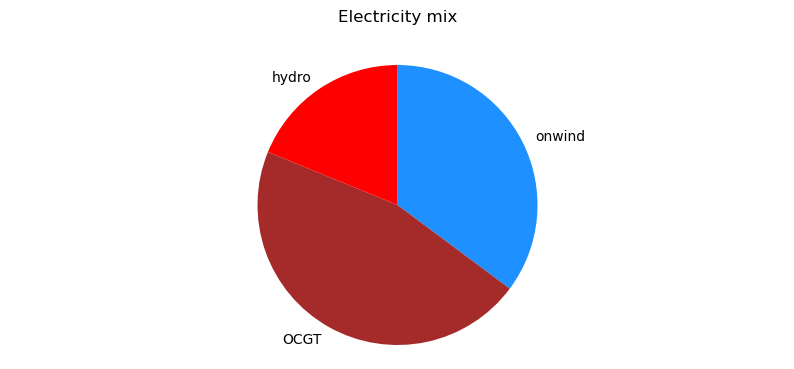

In [105]:
# Plot electricity mix
energy_production = network.generators_t.p
energy_sum = energy_production.sum(axis=0)
energy_sum = energy_sum[energy_sum != 0]

fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
plt.pie(energy_sum.values, labels=energy_sum.index, colors=energy_sum.index.map(network.carriers.color), startangle=90, counterclock=False);
plt.axis('equal')
plt.title('Electricity mix', y=1.07)
plt.show()

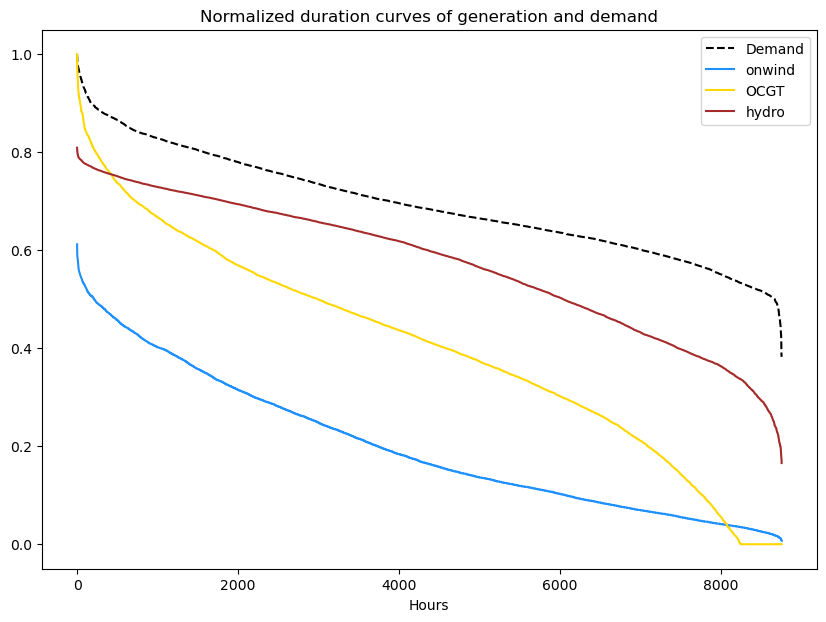

In [106]:
# Plot duration curves of generation and demand
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot((demand/max(demand)).sort_values(ascending=False).reset_index(drop=True), label="Demand", color="black", linestyle="--")

for i, col in enumerate(energy_sum.index):
    ax.plot((energy_production[col]/gen_cap[col]).sort_values(ascending=False).reset_index(drop=True), label=col, color=colors[i])

plt.legend()
plt.title("Normalized duration curves of generation and demand")
plt.xlabel("Hours")
plt.show()

#### Add net load curve

## B: CO2 limits

In [107]:
# Add a CO2 limit constraint, for now a dummy value
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=119E5, #11.9MtCO2
    type="primary_energy",
)

In [108]:
# Prepare for sensitivity analysis
sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}
co2_price = {}

# Compute the total system cost (capital + operational) for the current network
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

# Define the CO2 limits for sensitivity analysis and run the optimization for each limit
co2Limits = [50, 25, 11.9, 6.23, 3, 0]
for co2 in co2Limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6 # MtCO2/a
    
    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

    
    sensitivity_cost[co2] = system_cost(network)
    sensitivity_capacity[co2] = network.generators.p_nom_opt.copy()
    sensitivity_production[co2] = network.generators_t.p.sum(axis=0)
    co2_price[co2] = -network.global_constraints.mu['CO2Limit']

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.42it/s]
INFO:linopy.io: Writing time: 0.93s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-_57hrn73.lp
INFO:gurobipy:Reading time = 0.30 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267539 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver 

KeyboardInterrupt: 

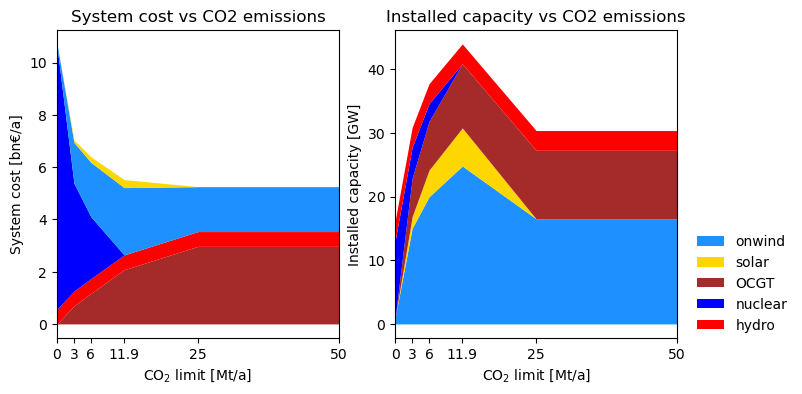

In [ ]:
sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T.div(1e3)  # GW
sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a

# Include only technologies that are used in the network
sens_cost = sens_cost.loc[:, sens_cost.sum() != 0]
sens_cap = sens_cap.loc[:, sens_cap.sum() != 0]

fix, ax = plt.subplots(1,2, figsize=(10, 20))
# Plot system cost vs CO2 emissions
sens_cost.plot.area(
    ax = ax[0],
    stacked=True, linewidth=0,
    color=sens_cost.columns.map(network.carriers.color),
    figsize=(4, 4), xlim=(min(co2Limits), max(co2Limits)),
    xlabel=r"CO$_2$ limit [Mt/a]",
    ylabel="System cost [bn€/a]",
    title="System cost vs CO2 emissions",
)
ax[0].set_xticks(co2Limits, co2Limits)
ax[0].get_legend().remove()

sens_cap.plot.area(ax = ax[1], 
                  stacked = True, linewidth=0,
                  color = sens_cap.columns.map(network.carriers.color),
                  figsize=(8, 4), xlim=(min(co2Limits), max(co2Limits)),
                    xlabel=r"CO$_2$ limit [Mt/a]",
                    ylabel="Installed capacity [GW]",
                    title="Installed capacity vs CO2 emissions",
)
ax[1].set_xticks(co2Limits, co2Limits)
ax[1].legend(frameon=False, loc=(1.05, 0))
plt.show()

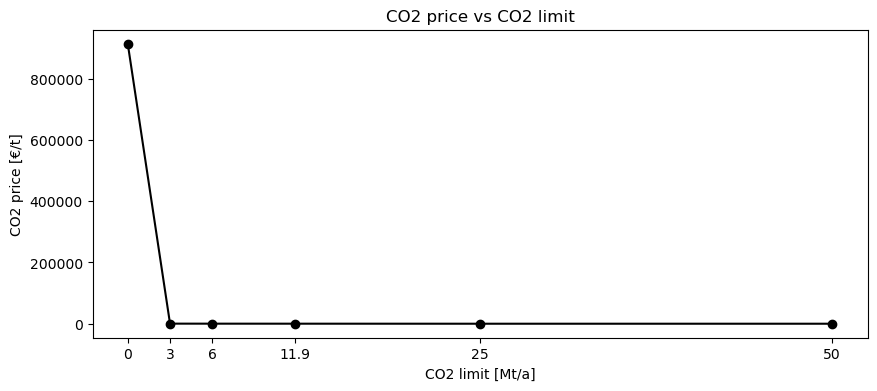

In [ ]:
# Plot CO2 price vs CO2 limit
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(co2Limits, co2_price.values(), marker="o", color="black")
ax.set_xticks(co2Limits, co2Limits)
ax.set_xlabel("CO2 limit [Mt/a]")
ax.set_ylabel("CO2 price [€/t]")
ax.set_title("CO2 price vs CO2 limit")
plt.show()

## C: new weather

In [ ]:
weather_years = [2001, 2010, 2015, 2017]

sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}

for year in weather_years:
    onshore = onshore_all[country].loc[onshore_all.index.year == year]
    solar = solar_all[country].loc[solar_all.index.year == year]
    hydro = hydro_extended.loc[hydro_extended.index.year == year]

    # Update model
    network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values, solar=solar.values, hydro=hydro.values)

    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})


    sensitivity_cost[year] = system_cost(network)
    sensitivity_capacity[year] = network.generators.p_nom_opt.copy()
    sensitivity_production[year] = network.generators_t.p.copy()

sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T

DatetimeIndex(['2015-03-26 22:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
DatetimeIndex(['2015-03-26 22:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
INFO:linopy.io: Writing time: 1.48s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-ygy1l3_n.lp
INFO:gurobipy:Reading time = 0.44 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267554 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 1.04e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-p

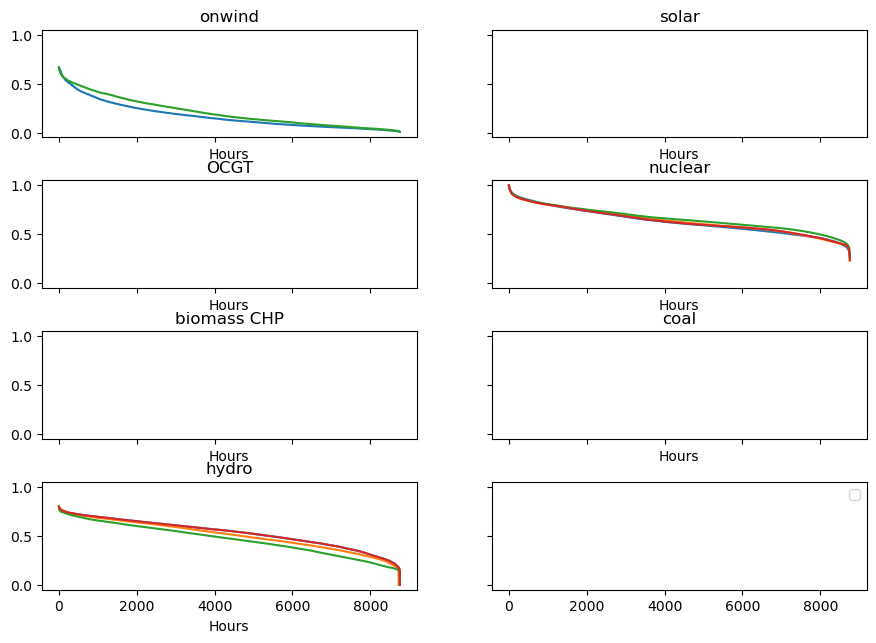

In [ ]:
# Plot duration curves for each technology and year
fig , ax = plt.subplots(4, 2, figsize=(10,7), sharex=True, sharey=True)

for i, tech in enumerate(sens_cap.columns):
    for year in weather_years:
        ax[i//2, i%2].plot((sensitivity_production[year][tech]/sens_cap.loc[year, tech]).sort_values(ascending=False).reset_index(drop=True),
                            label=year)
        ax[i//2, i%2].set_title(tech)
        ax[i//2, i%2].set_xlabel("Hours")

plt.legend(loc="best")
plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()

## D: Add storage

In [ ]:
# Reset basis year to 2015
year = 2015
network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6 # MtCO2/a

onshore = onshore_all[country].loc[onshore_all.index.year == year]
solar = solar_all[country].loc[solar_all.index.year == year]
hydro = hydro_extended.loc[hydro_extended.index.year == year]

# Update model
network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values, solar=solar.values, hydro=hydro.values)

# Add storage bus
network.add("Carrier", "battery storage", co2_emissions=0, color="purple")
network.add("Bus", "FIN_storage", carrier="battery storage")
carriers.append("battery storage")

# Add storage load to represent the battery charging
network.add(
    "StorageUnit",
    "battery storage",
    bus="FIN_storage",
    carrier="battery storage",
    capital_cost = costs.at["battery storage", "capital_cost"],
    efficiency_store=1,
    efficiency_dispatch=1,
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

# Add link to represent the battery inverter
network.add(
    "Link",
    "battery",
    bus0="FIN_el",
    bus1="FIN_storage",
    p_nom_extendable=True,
    efficiency=costs.at["battery inverter", "efficiency"],
    capital_cost=costs.at["battery inverter", "capital_cost"],
    p_max_pu = 1,
    p_min_pu = -1,
)

# Optimize with reduced output
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 38.82it/s]
INFO:linopy.io: Writing time: 1.86s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-8pos5x7n.lp
INFO:gurobipy:Reading time = 0.54 seconds
INFO:gurobipy:obj: 219011 rows, 96369 columns, 451501 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96369 primals, 219011 duals
Objective: 9.76e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, Storage

<Axes: xlabel='snapshot'>

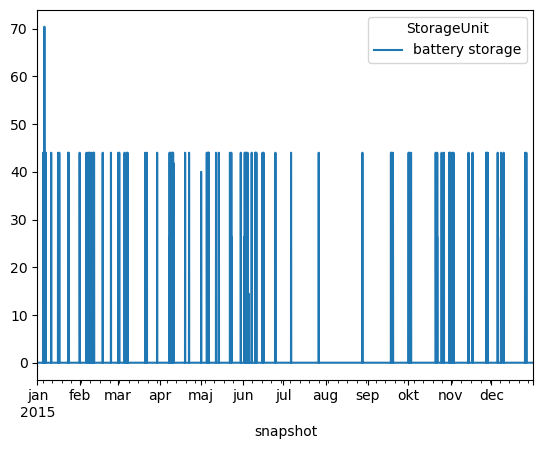

In [ ]:
network.storage_units_t.p_store.plot()

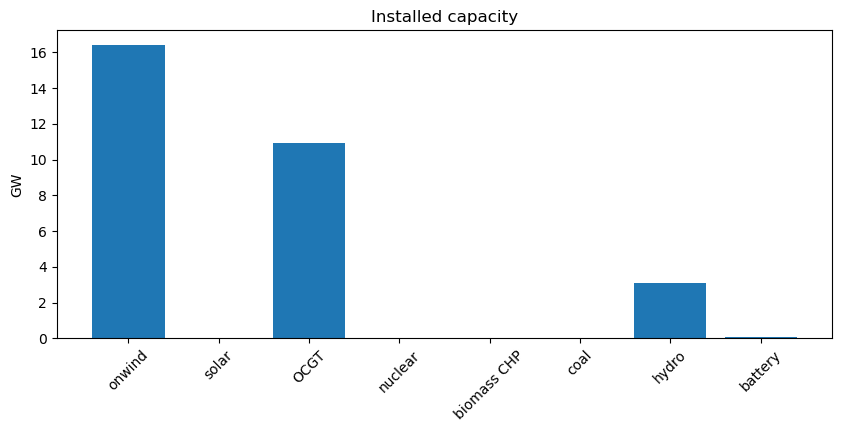

In [ ]:
# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.links.p_nom_opt], axis=0)
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

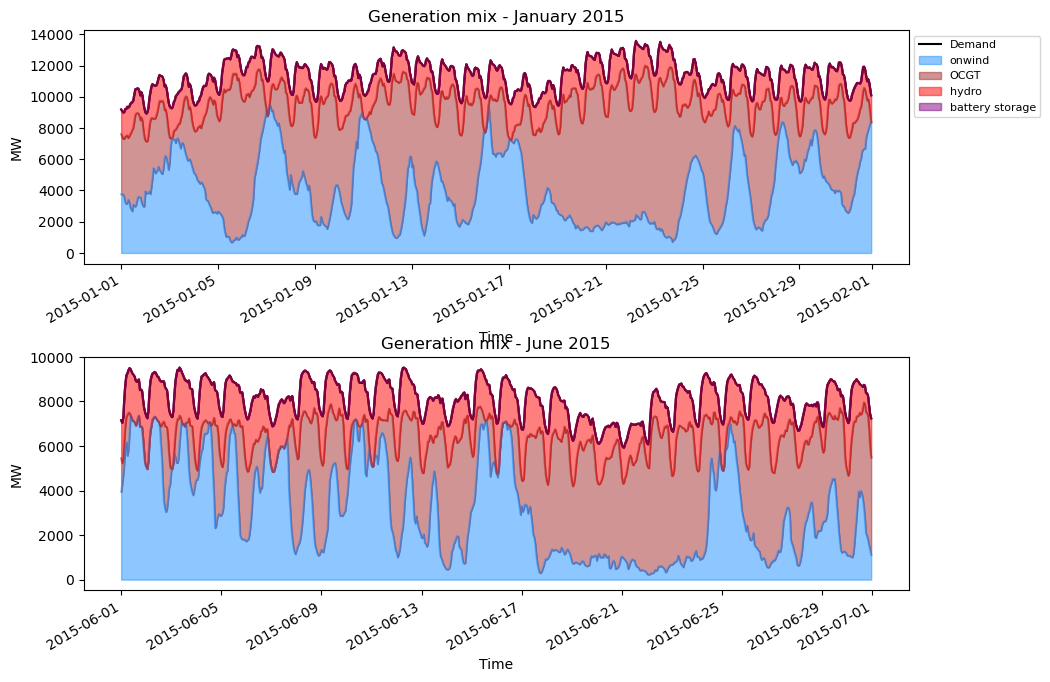

In [ ]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-31"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-30"

demand_jan = demand.loc[start_date_jan:end_date_jan]
generator_jan = total_gen_prod.loc[start_date_jan:end_date_jan,  (total_gen_prod != 0).any(axis=0)]

demand_jun = demand.loc[start_date_jun:end_date_jun, ]
generator_jun = total_gen_prod.loc[start_date_jun:end_date_jun, (total_gen_prod != 0).any(axis=0)]


fig, ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January 2015")
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Time")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June 2015")
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Time")

plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()

## E: Determine CO2 price for CO2 target

In [ ]:
# Set CO2 limit to 0 and optimize again
network.global_constraints.loc["CO2Limit", "constant"] = 6 * 1E6 # MtCO2/a

# Optimize model
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

# Extract CO2 price
co2_price = -network.global_constraints.mu['CO2Limit']

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 30.29it/s]
INFO:linopy.io: Writing time: 2.33s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-z6ug20su.lp
INFO:gurobipy:Reading time = 0.60 seconds
INFO:gurobipy:obj: 219011 rows, 96369 columns, 451501 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96369 primals, 219011 duals
Objective: 6.58e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, Storage

CO2 price: 166.5648137589583 €/tCO2


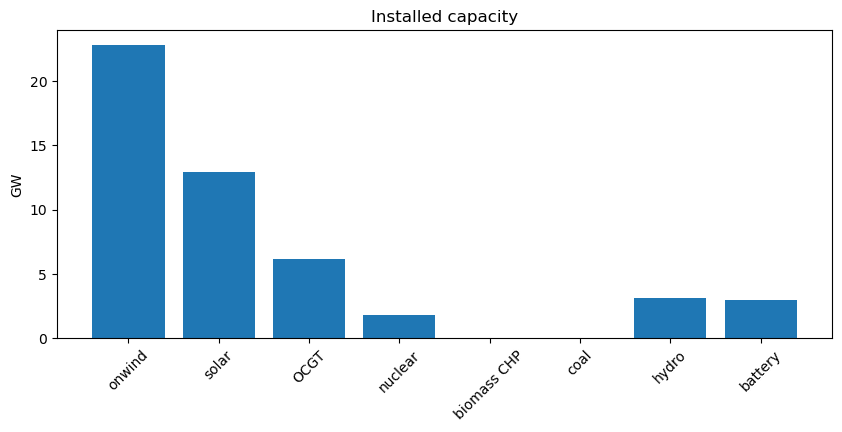

In [ ]:

print(f"CO2 price: {co2_price} €/tCO2")
# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.links.p_nom_opt], axis=0)
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

## F: Connect with neighbours

In [143]:
### Connect with estonia and sweden ###
network = pypsa.Network()
network.set_snapshots(snapshots.values)
countries = ["FIN", "EST", "SWE"]
coordinates = {
    "FIN": (64, 26),
    "EST": (59, 26),
    "SWE": (62, 15),
}

# Add the new countries to the network
for country in countries:
    network.add("Bus", f"{country}_el", y = coordinates[country][0], x = coordinates[country][1])
    network.add("Bus", f"{country}_storage", carrier="battery storage", y = coordinates[country][0], x = coordinates[country][1])


    CF = pd.DataFrame(1, index=snapshots, columns=carriers)
    CF = CF.assign(onwind=onshore_all.loc[onshore_all.index.year == year, country].values,
                   solar=solar_all.loc[solar_all.index.year == year, country].values, 
                   hydro=hydro_2015.values )
    
    for carrier in carriers:
        if carrier != "battery storage":
            network.add("Generator", f"{carrier}_{country}", bus=f"{country}_el", p_nom_extendable=True,
                        p_max_pu=CF[carrier].values,
                        marginal_cost=costs.at[carrier, "marginal_cost"],
                        efficiency=costs.at[carrier, "efficiency"],
                        capital_cost=costs.at[carrier, "capital_cost"],
                        carrier=carrier
            )

    # Add electricity load
    network.add("Load", f"el_load_{country}", bus=f"{country}_el", p_set=demand_all.loc[demand.index.year == year, country].values)

    # Add storage bus
    network.add("StorageUnit", f"{country}_storage",
                bus=f"{country}_storage",
                carrier="battery storage",
                capital_cost = costs.at["battery storage", "capital_cost"],
                efficiency_store=1,
                efficiency_dispatch=1,
                p_nom_extendable=True,
                cyclic_state_of_charge=True,
    )

    # Add link to represent the battery inverter
    network.add("Link", f"{country}_battery",
                bus0=f"{country}_el",
                bus1=f"{country}_storage",
                p_nom_extendable=True,
                efficiency=costs.at["battery inverter", "efficiency"],
                capital_cost=costs.at["battery inverter", "capital_cost"],
                p_max_pu = 1,
                p_min_pu = -1,
    )   

# Do not allow estonia to install hydro
network.generators.loc["hydro_EST", "p_nom_max"] = 0

# Limit hydro capacity for finland and sweden
network.generators.loc["hydro_FIN", "p_nom_max"] = 3100 # MW
network.generators.loc["hydro_SWE", "p_nom_max"] = 16_301 # MW

# Add interconnectors between countries
network.add("Link", "FIN-EST", bus0 = "FIN_el", bus1 = "EST_el", p_nom = 5e3, efficiency=1, capital_cost=0, p_max_pu=1, p_min_pu=-1)
network.add("Line", "FIN-SWE", bus0 = "FIN_el", bus1 = "SWE_el", x = 1, r = 1, s_nom = 0, capital_cost=0, s_max_pu=1)



# with suppress_stdout():
#     network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

In [133]:
# print(network.lines.s_nom_opt)
# network.lines_t.p0.plot()

In [134]:
# network.links.p_nom_opt

In [135]:
# import cartopy.crs as ccrs

# fig, ax = plt.subplots(figsize=(10,4))
# network.plot(bus_sizes = 1/5, margin = 1, projection=ccrs.EqualEarth(),
#     color_geomap=True,
#     line_colors=network.lines_t.p0.mean().abs(),)
# plt.show()

In [136]:
# network.generators.p_nom_opt.plot.bar()

In [137]:
# gen = network.generators.assign(g=network.generators_t.p.sum()).groupby(["bus", "carrier"]).g.sum()
# gen_unstacked = gen.unstack()
# gen_unstacked.div(1E3).plot.bar()
# plt.ylabel("GWh")
# plt.show()

## G: Add sector coupling

In [138]:
# Import temperature data
temp_est = pd.read_excel("Estland_temp.xlsx")
temp_est.index = pd.to_datetime(temp_est['Päev'].astype(str) + '-' + 
                                temp_est['Kuu'].astype(str) + '-' + 
                                temp_est['Aasta'].astype(str) + " " +
                                temp_est["Kell (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S')
temp_est = temp_est["Õhutemperatuur °C"]

temp_swe = pd.read_csv("Sverige_temp.csv")
temp_swe.index = pd.to_datetime(temp_swe['Day'].astype(str) + '-' + 
                                temp_swe['Month'].astype(str) + '-' + 
                                temp_swe['Year'].astype(str) + " " +
                                temp_swe["Time [UTC]"].astype(str),
                                format='%d-%m-%Y %H:%M')
temp_swe = temp_swe["Average temperature [°C]"]

temp_fin = pd.read_csv("Finland_temp.csv", sep=";")
temp_fin.index = pd.to_datetime(temp_fin['Datum'].astype(str) + " " +
                                temp_fin["Tid (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S') 
temp_fin = temp_fin["Lufttemperatur"]

temperature_df = pd.concat(
    [temp_est.rename("EST"), temp_fin.rename("FIN"), temp_swe.rename("SWE")], 
    axis=1
)

In [144]:
# backpressure limit
c_m = 0.75

# marginal loss of electricity generation for each additional generation of heat
c_v = 0.15

heat_generatos = ["CHP generator", "CHP boiler", "gas boiler"]
T_sink = 55 # temperature of the heat sink

def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return (6.81 - 0.121 * delta_t + 0.00063 * delta_t**2).values

network.add("Bus", "gas") # Dummy gas bus
network.add("Store", "gas", e_initial=1e18, e_nom=1e18, bus="gas") 


for country in countries:
    network.add("Bus", f"{country}_heat", y = coordinates[country][0], x = coordinates[country][1])
    network.add("Load", f"heat_load_{country}", bus=f"{country}_heat", p_set=heat_all.loc[heat_all.index.year == year, country].values)


    network.add(
        "Link",
        f"CHP generator_{country}",
        bus0="gas",
        bus1=f"{country}_el",
        efficiency=costs.loc["central gas CHP", "efficiency"],
        p_nom_extendable=True,
        marginal_cost=costs.loc["central gas CHP", "marginal_cost"], # €/MWh
        capital_cost=costs.at["central gas CHP", "capital_cost"],  # €/MWe/a
        carrier = "OCGT"
    )

    network.add(
        "Link",
        f"CHP boiler_{country}",
        bus0="gas",
        bus1=f"{country}_heat",
        p_nom_extendable=True,
        carrier ="OCGT",
    )


    network.add(
        "Link",
        f"gas boiler_{country}",
        bus0="gas",
        bus1=f"{country}_heat",
        capital_cost=costs.at["gas boiler steam", "capital_cost"],  # €/MW/a
        marginal_cost=costs.at["gas boiler steam", "marginal_cost"],  # €/MWh
        p_nom_extendable=True,
        efficiency=costs.at["gas boiler steam", "efficiency"],
        carrier = "OCGT"
    )

    network.links.at[f"CHP boiler_{country}", "efficiency"] = (network.links.at[f"CHP generator_{country}", "efficiency"] / c_v)

    model = network.optimize.create_model()
    link_p = model.variables["Link-p"]
    # Guarantees back-pressure line
    model.add_constraints(
        c_m * float(network.links.at[f"CHP boiler_{country}", "efficiency"]) * link_p.sel(Link=f"CHP boiler_{country}")
        - float(network.links.at[f"CHP generator_{country}", "efficiency"]) * link_p.sel(Link=f"CHP generator_{country}")
        <= 0,
        name=f"backpressure_{country}",)
    
    # Guarantees top iso fuel line
    model.add_constraints(
        link_p.sel(Link=f"CHP boiler_{country}") + link_p.sel(Link=f"CHP generator_{country}")
        - network.links.at[f"CHP generator_{country}", "p_nom"]
        <= 0,
        name=f"top_iso_fuel_line_{country}",
    )

    # Add heat pump
    temp = temperature_df.loc[temperature_df.index.year == year, f"{country}"]

    network.add(
        "Link",
        f"heat pump_{country}",
        bus0=f"{country}_el",
        bus1=f"{country}_heat",
        efficiency=cop(temp),
        p_nom_extendable=True,
        capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],  # €/MWe/a
        marginal_cost=costs.at["central air-sourced heat pump", "marginal_cost"],  # €/MWh
    )




In [141]:
network.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
FIN_battery,FIN_el,FIN_storage,,AC,0.960000,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
EST_battery,EST_el,EST_storage,,AC,0.960000,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
SWE_battery,SWE_el,SWE_storage,,AC,0.960000,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
FIN-EST,FIN_el,EST_el,,AC,1.000000,0,inf,5000.0,False,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP generator_FIN,gas,FIN_el,,OCGT,0.410000,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP boiler_FIN,gas,FIN_heat,,OCGT,2.733333,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
gas boiler_FIN,gas,FIN_heat,,OCGT,0.930000,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump_FIN,FIN_el,FIN_heat,,AC,1.000000,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP generator_EST,gas,EST_el,,OCGT,0.410000,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [145]:
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 12/12 [00:00<00:00, 13.70it/s]
INFO:linopy.io: Writing time: 7.08s
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-jgg8wvbd.lp
INFO:gurobipy:Reading time = 1.89 seconds
INFO:gurobipy:obj: 963642 rows, 429279 columns, 1923437 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 429279 primals, 963642 duals
Objective: 8.22e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper

In [146]:
network.links.p_nom_opt

Link
FIN_battery              0.000000
EST_battery            368.375000
SWE_battery            813.500000
FIN-EST               5000.000000
CHP generator_FIN    19565.853659
CHP boiler_FIN        7832.286934
gas boiler_FIN           0.000000
heat pump_FIN            0.000000
CHP generator_EST     8231.707317
CHP boiler_EST        1210.523017
gas boiler_EST           0.000000
heat pump_EST            0.000000
CHP generator_SWE    42617.073171
CHP boiler_SWE        7771.583779
gas boiler_SWE           0.000000
heat pump_SWE            0.000000
Name: p_nom_opt, dtype: float64

In [ ]:
network.links_

In [148]:
network.links_t.efficiency

Link,heat pump_FIN,heat pump_EST,heat pump_SWE
snapshot,,,
2015-01-01 00:00:00,2.134365,2.199429,2.060750
2015-01-01 01:00:00,2.134365,2.199429,2.097249
2015-01-01 02:00:00,2.139718,2.161254,2.150461
2015-01-01 03:00:00,2.155851,2.193937,2.145083
2015-01-01 04:00:00,2.155851,2.210449,2.150461
...,...,...,...
2015-12-31 19:00:00,1.930589,1.666818,1.782083
2015-12-31 20:00:00,1.959870,1.650522,1.742641
2015-12-31 21:00:00,1.974681,1.646480,1.751318


## H: Explore new topic